<a href="https://colab.research.google.com/github/aas161/NeuroEvo-SANE/blob/main/SANE_NeuroEv_BMI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import csv
import os
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, log_loss, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import networkx as nx

BMI Dataset URL: https://www.kaggle.com/datasets/yasserh/bmidataset/data

This data frame contains the following columns:

- Gender : Male (0) / Female (1);

- Height : Number (cm);

- Weight : Number (kg).

Index:

- 0 - Extremely Weak;

- 1 - Weak;

- 2 - Normal;

- 3 - Overweight;

- 4 - Obesity;

- 5 - Extreme Obesity.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NeuroEvo/BMI_Dataset.csv')
df['Gender'] = df['Gender'].replace(['Male', 'Female'], [0, 1])

In [ ]:
df.head(8)

,Gender,Height,Weight,Index
0,0,174,96,4
1,0,189,87,2
2,1,185,110,4
3,1,195,104,3
4,0,149,61,3
5,0,189,104,3
6,0,147,92,5
7,0,154,111,5


In [ ]:
print("Количество примеров в каждом классе:\n\n", df.iloc[:,3:].value_counts())

Количество примеров в каждом классе:

 Index
5        198
4        130
2         69
3         68
1         22
0         13
Name: count, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Gender  500 non-null    int64
 1   Height  500 non-null    int64
 2   Weight  500 non-null    int64
 3   Index   500 non-null    int64
dtypes: int64(4)
memory usage: 15.8 KB


In [ ]:
df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'Reds')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
Gender,500.000000,0.510000,0.500401,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Height,500.000000,169.944000,16.375261,140.000000,140.000000,156.000000,159.000000,170.500000,184.000000,186.000000,199.000000,199.000000
Weight,500.000000,106.000000,32.382607,50.000000,50.000000,80.000000,84.000000,106.000000,136.000000,140.000000,160.000000,160.000000
Index,500.000000,3.748000,1.355053,0.000000,0.000000,3.000000,3.000000,4.000000,5.000000,5.000000,5.000000,5.000000


In [ ]:
# Разделение датасета на обучающую, тестовую и валидационную выборки
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Разделение на признаки и целевую переменную
x_train = train_data.drop('Index', axis=1)
y_train = np.array(train_data['Index'])

x_test = test_data.drop('Index', axis=1)
y_test = np.array(test_data['Index'])

x_val = val_data.drop('Index', axis=1)
y_val = np.array(val_data['Index'])

In [ ]:
scaler = MinMaxScaler()

# Нормализация выборок в диапозоне от 0 до 1
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [ ]:
print('Тренировочная выборка:', x_train.shape)
print('Тестовая выборка:', x_test.shape)
print('Валидационная выборка:', x_val.shape)

Тренировочная выборка: (320, 3)
Тестовая выборка: (100, 3)
Валидационная выборка: (80, 3)


In [ ]:
# Параметры НС
epochs = 100
total_neurons = 3000
total_blueprints = 600
hidden_neurons = 100
in_neurons = x_train.shape[1]
out_neurons = np.unique(y_train).shape[0]
connections = 8
patience = 10
model_name = 1

model_path = f"/content/drive/MyDrive/Colab Notebooks/NeuroEvo/models/model_{model_name}.npy"

In [ ]:
class Network:
    def __init__(self, neural_network_neurons, n_input_neurons, n_output_neurons, n_hidden_neurons):
        self.n_input_neurons = n_input_neurons
        self.n_output_neurons = n_output_neurons
        self.n_hidden_neurons = n_hidden_neurons
        self.neural_network_neurons = neural_network_neurons # список нейронов НС

    def forward(self, x):
        in_weights, out_weights = self.create_weights()
        return self.softmax(np.matmul(self.relu(np.matmul(x, in_weights)), out_weights))

    def create_weights(self):
        in_weights = np.zeros((self.n_input_neurons, self.n_hidden_neurons))
        out_weights = np.zeros((self.n_hidden_neurons, self.n_output_neurons))

        for i in range(0, self.n_hidden_neurons):
            hn_connections = self.neural_network_neurons[i]
            for j in range(0, len(hn_connections), 2):
                if (hn_connections[j] < self.n_input_neurons):
                    in_n_id = int(hn_connections[j])
                    in_weights[in_n_id, i] = hn_connections[j+1]
                else:
                    out_n_id = int(hn_connections[j] - self.n_input_neurons)
                    out_weights[i, out_n_id] = hn_connections[j+1]
        return in_weights, out_weights

    def relu(self, x):
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if x[i, j] < 0:
                    x[i, j] = 0
        return x

    def softmax(self, x):
        out = np.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                out[i, j] = np.exp(x[i, j]) / np.sum(np.exp(x[i]))
        return out

In [ ]:
class Sane:
    def __init__(self, epochs, loss_func, accuracy_score, num_neuron_pop, in_neurons, out_neurons, num_hidden_neurons, num_neuron_connect, num_blueprints, patience):
            self.epochs = epochs
            self.loss_func = loss_func
            self.accuracy_score = accuracy_score
            self.num_neuron_pop = num_neuron_pop
            self.num_hidden_neurons = num_hidden_neurons
            self.num_neuron_connect = num_neuron_connect
            self.num_blueprints = num_blueprints
            self.in_neurons = in_neurons
            self.out_neurons = out_neurons
            self.early_stopping = StopTraining("model", patience)

    # Функция оптимизации весов и связей НС
    def evolve(self, x_train, y_train, x_val, y_val, model_name):
        loss_arr = []
        accuracy = []
        epoch = 0

        # Генерация популяции нейронов и их комбинаций
        population, blueprints = self.generate_population()
        while (epoch < self.epochs and not self.early_stopping.early_stop):

            # Сброс приспособленности ИНС
            blueprint_fitness = np.zeros(self.num_blueprints)
            # Сброс приспособленности нейронов
            neuron_fitness = np.zeros(self.num_neuron_pop)
            # Количество вхождений нейронов в ИНС
            num_neuron_include = np.ones(self.num_neuron_pop)

            # Пересчет приспособленности комбинаций
            for bp_id in range(blueprints.shape[0]):
                net = population[blueprints[bp_id]]
                model = Network(net, self.in_neurons, self.out_neurons, self.num_hidden_neurons)
                preds = model.forward(x_train)
                loss = self.loss_func(y_train, preds)
                blueprint_fitness[bp_id] = loss

            # Сортировка моделей по убыванию приспособленности
            sort_id = np.argsort(blueprint_fitness)
            blueprints = blueprints[sort_id]
            blueprint_fitness = blueprint_fitness[sort_id]

            # Сохранение ИНС с лучшей приспособленностью
            best_loss_train = blueprint_fitness[0]
            net = population[blueprints[0]]
            model = Network(net, self.in_neurons, self.out_neurons, self.num_hidden_neurons)
            preds = model.forward(x_val)
            best_loss_val = self.loss_func(y_val, preds)
            best_acc_val = self.accuracy_score(y_val, np.argmax(preds, axis=1))
            print('Эпоха:', epoch + 1)
            print('Лучший Loss:', best_loss_val)
            print('Лучшая Accuracy:', best_acc_val)
            loss_arr.append(best_loss_val)
            accuracy.append(best_acc_val)
            self.early_stopping(best_loss_val, net, epoch, model_name)

            # Вычисление средней приспособленности нейронов
            for _ in range(1000):
                # Случайным образом выбераются нейроны из популяции
                random_NN = np.random.randint(0, self.num_neuron_pop, size=(self.num_hidden_neurons))

                # Увеличить число вхождений для каждого участвующего нейрона
                for n_id in np.unique(random_NN):
                    num_neuron_include[n_id] += 1

                # Создается ИНС
                net = population[random_NN]
                model = Network(net, self.in_neurons, self.out_neurons, self.num_hidden_neurons)

                # ИНС оценивается на модели
                preds = model.forward(x_train)
                loss = self.loss_func(y_train, preds)

                # Добавляем оценку сети к приспособленности нейрона
                neuron_fitness = self.update_neuron_fitness(neuron_fitness, random_NN, loss)

            # Усреднить приспособленности нейронов по числу вхождений нейрона в НС
            neuron_fitness /= num_neuron_include

            # Сортировка нейронов по убыванию приспособленности
            sort_id = np.argsort(neuron_fitness)
            population = population[sort_id]
            neuron_fitness = neuron_fitness[sort_id]

            # Обновление указателей на изменившиеся индексы нейронов
            for i in range(self.num_blueprints):
                for j in range(self.num_hidden_neurons):
                    blueprints[i, j] = np.where(sort_id == blueprints[i, j])[0][0]

            # Скрещивание нейронов
            population = self.neuron_crossover(population)

            # Мутация нейронов
            population = self.neuron_mutation(population, 0.001)

            # Скрещивание комбинаций
            blueprints = self.blueprint_crossover(blueprints)

            # Мутация комбинаций
            blueprints = self.blueprint_mutation(blueprints, 0.01, 0.5)

            epoch += 1
        return population[blueprints[0]], loss_arr, accuracy, epoch

    # Обновление значений приспособленности нейронов
    def update_neuron_fitness(self, n_fit, n_ids_in, loss):
        for i in np.unique(n_ids_in):
            n_fit[i] += loss
        return n_fit

    def neuron_mutation(self, populat, p):
        # Вероятность мутации индекса нейрона
        pid = 1 - (1 - p)**8
        # Вероятность мутации связи
        pw = 1 - (1 - p)**16
        for i in range(self.num_neuron_pop):
            for j in range(populat[i].shape[0]):
                if (j % 2 == 0):
                    if (np.random.random() < pid):
                        n_id = np.random.randint(0, self.in_neurons + self.out_neurons)
                        populat[i, j] = n_id
                else:
                    if (np.random.random() < pw):
                        populat[i, j] = np.random.random() - 0.5
        return populat

    def neuron_crossover(self, populat):
        # Количество нейронов, которые учавcтсвуют в скрещивании
        n_cross_neurons = int(0.25*populat.shape[0])
        for i in range(1, n_cross_neurons, 2):
            # Индексы скрещиваемых нейронов
            n1_id = np.random.randint(0, n_cross_neurons)
            n2_id = np.random.randint(0, n_cross_neurons)
            # Точка разрыва
            p = np.random.randint(1, self.num_neuron_connect*2 - 1)
            if (n1_id != n2_id):
                populat[-i] = np.concatenate((populat[n1_id, 0:p], populat[n2_id, p:self.num_neuron_connect*2]), axis=0)
                populat[-(i+1)] = populat[n1_id]
        return populat

    def blueprint_mutation(self, bp, p1, p2):
        n_mut_bp = int(0.75*self.num_blueprints)
        n_mut_neurons = int(0.25*self.num_neuron_pop)
        # Вероятность мутации индекса нейрона
        p2 = p2 + p1
        for i in range(n_mut_bp, self.num_blueprints):
            for j in range(self.num_hidden_neurons):
                pm = np.random.random()
                if (pm < p1):
                    n_id = np.random.randint(0, self.num_neuron_pop - n_mut_neurons)
                    bp[i, j] = n_id
                if (pm > p1 and pm < p2):
                    n_id = np.random.randint(self.num_neuron_pop - n_mut_neurons, self.num_neuron_pop)
                    bp[i, j] = n_id
        return bp

    def blueprint_crossover(self, bp):
        n_cross_bp = int(0.25*self.num_blueprints)
        for i in range(1, n_cross_bp, 2):
            # Индексы скрещиваемых нейронов
            n1_id = np.random.randint(0, n_cross_bp)
            n2_id = np.random.randint(0, n_cross_bp)
            # Точка разрыва
            p = np.random.randint(1, self.num_hidden_neurons)
            if (n1_id != n2_id):
                bp[-i] = np.concatenate((bp[n1_id, 0:p], bp[n2_id, p:self.num_hidden_neurons]), axis=0)
                bp[-(i+1)] = bp[n1_id]
        return bp

    # Инициализация популяции нейронов и их комбинаций
    def generate_population(self):
        io_neuron = self.in_neurons + self.out_neurons
        population = np.zeros((self.num_neuron_pop, self.num_neuron_connect*2))
        for i in range(0, self.num_neuron_pop):
            chosen_neurons = set()
            for j in range(0, self.num_neuron_connect*2 - 1, 2):
                while True:
                    neuron_id = np.random.randint(0, self.in_neurons + self.out_neurons)
                    if neuron_id not in chosen_neurons:
                        chosen_neurons.add(neuron_id)
                        break
                population[i][j] = neuron_id
                population[i][j+1] = np.random.random() - 0.5
        blueprints = np.zeros((self.num_blueprints, self.num_hidden_neurons), dtype=int)
        for i in range(0, self.num_blueprints):
            blueprints[i] = np.random.randint(0, self.num_neuron_pop, size=(self.num_hidden_neurons))

        return population, blueprints

In [ ]:
class StopTraining:
    def __init__(self, model_name="model", patience=patience):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.save_checkpoint = SaveNetwork(model_name)

    def __call__(self, val_loss, model, epoch, count):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, epoch, model, count)
        elif score < self.best_score:
            self.counter += 1
            print(f'\nСчетчик ранней остановки: {self.counter} из {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, epoch, model, count)
            self.counter = 0

In [ ]:
class SaveNetwork:
    def __init__(self, model_name, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
        self.model_name = model_name

    def __call__(self, current_valid_loss, epoch, model, counter):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"Сохранение лучшей модели НС на эпохе: {epoch+1}\n")
            np.save(f'/content/drive/MyDrive/Colab Notebooks/NeuroEvo/models/{self.model_name}_{counter}', model)

In [ ]:
# Обучение НС
sane = Sane(epochs, log_loss, accuracy_score, total_neurons, in_neurons, out_neurons, hidden_neurons, connections, total_blueprints, patience)
_, loss_arr, accuracy, epoch = sane.evolve(x_train, y_train, x_val, y_val, model_name)

Эпоха: 1
Лучший Loss: 1.6149275955870948
Лучшая Accuracy: 0.3875
Сохранение лучшей модели НС на эпохе: 1

Эпоха: 2
Лучший Loss: 1.5131351542344222
Лучшая Accuracy: 0.3375
Сохранение лучшей модели НС на эпохе: 2

Эпоха: 3
Лучший Loss: 1.4162521435193152
Лучшая Accuracy: 0.3375
Сохранение лучшей модели НС на эпохе: 3

Эпоха: 4
Лучший Loss: 1.2842783217436362
Лучшая Accuracy: 0.45
Сохранение лучшей модели НС на эпохе: 4

Эпоха: 5
Лучший Loss: 1.319781423955573
Лучшая Accuracy: 0.35

Счетчик ранней остановки: 1 из 10

Эпоха: 6
Лучший Loss: 1.264787940610001
Лучшая Accuracy: 0.3625
Сохранение лучшей модели НС на эпохе: 6

Эпоха: 7
Лучший Loss: 1.2322776435941087
Лучшая Accuracy: 0.3875
Сохранение лучшей модели НС на эпохе: 7

Эпоха: 8
Лучший Loss: 1.2003552686445584
Лучшая Accuracy: 0.4125
Сохранение лучшей модели НС на эпохе: 8

Эпоха: 9
Лучший Loss: 1.1926208354395165
Лучшая Accuracy: 0.4875
Сохранение лучшей модели НС на эпохе: 9

Эпоха: 10
Лучший Loss: 1.1691243226860788
Лучшая Accuracy

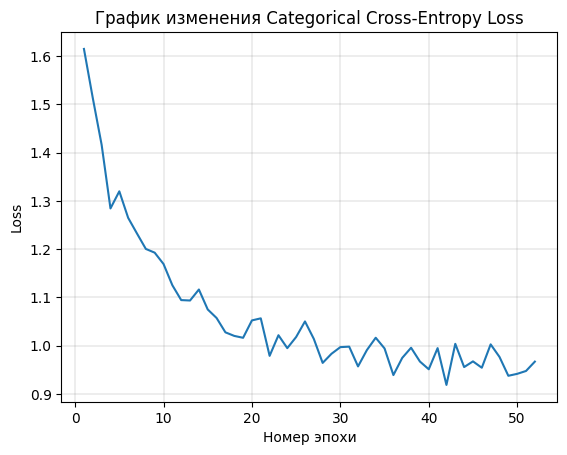

In [ ]:
# График изменения Loss
plt.plot(range(1, epoch+1), loss_arr)
plt.xlabel('Номер эпохи')
plt.ylabel('Loss')
plt.title('График изменения Categorical Cross-Entropy Loss')
plt.grid(axis = 'x', color = 'grey', linestyle = '-', linewidth = 0.2)
plt.grid(axis = 'y', color = 'grey', linestyle = '-', linewidth = 0.2)
plt.show()

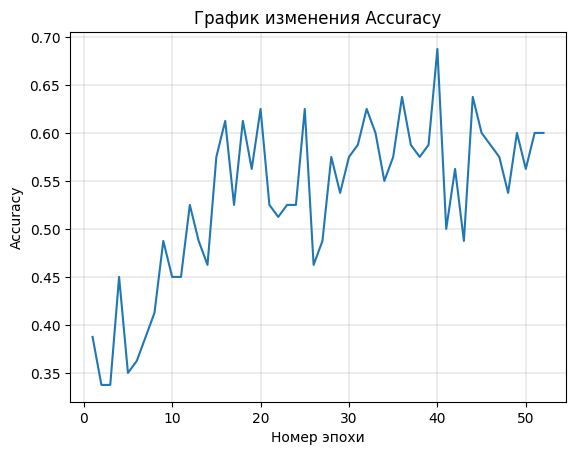

In [ ]:
# График изменения Accuracy
plt.plot(range(1, epoch+1), accuracy)
plt.xlabel('Номер эпохи')
plt.ylabel('Accuracy')
plt.title('График изменения Accuracy')
plt.grid(axis = 'x', color = 'grey', linestyle = '-', linewidth = 0.2)
plt.grid(axis = 'y', color = 'grey', linestyle = '-', linewidth = 0.2)
plt.show()

Оценка модели на тестовой выборке